# Outline

* [1. Lotka-Volterra](#section1)
* [2. Ensemble Kalman Filter](#section2)
* [3. EnKF vs PKF](#section3)

In [1]:
from module.generated_models import adv_lv, pkf_adv_lv

import numpy as np
import matplotlib.pyplot as plt

from model import LotkaVolterra, LotkaVolterra_PKF
from module.tools import draw_covariance_matrix

# 1. Lotka-Volterra :


More precisely, the reactions take the form [Ladesmaki2016lect]
\begin{eqnarray}
A + X &\overset{k_1}{\rightarrow}& 2X, \,\, (1) \\
X + Y &\overset{k_2}{\rightarrow}& 2Y, \,\, (2) \\
Y &\overset{k_3}{\rightarrow}& B. \,\, (3) 
\end{eqnarray}

which remains to the reaction $A \rightarrow B$. The kinetic of the reaction, deduced from the **mass action law** _for reaction rate_ writes
\begin{eqnarray}
\frac{d[X]}{dt} &=& k_1 [A][X] - k_2 [X][Y],\\
\frac{d[Y]}{dt} &=& k_2 [X][Y] - k_3 [Y].
\end{eqnarray}
When the concentration of $A$ is constant (that is in excess), the system simplifies as 
\begin{eqnarray}
\frac{d[X]}{dt} &=& k_1 [X] - k_2 [X][Y],\\
\frac{d[Y]}{dt} &=& k_2 [X][Y] - k_3 [Y].
\end{eqnarray}

### Lotka Volterra's orbit solutions

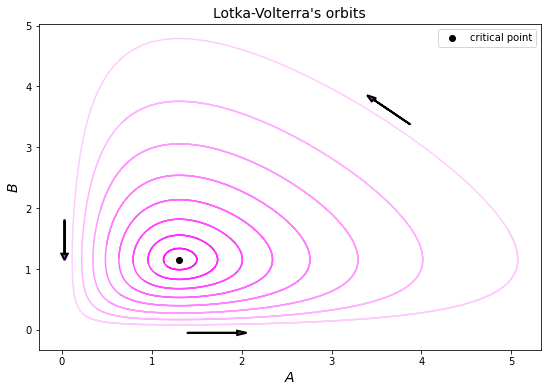

In [2]:
enkf = adv_lv(shape=(1,),u=np.zeros(1),k_1 = 0.75,k_2=0.65,k_3=0.85)
enkf.set_dt(0.05)
times = enkf.window(15)
stability_point = np.array([enkf.k_3/enkf.k_2,enkf.k_1/enkf.k_2])
plt.figure(figsize=(9,6))
r = np.array([0.0,1.0,0.0])


n_traj = 10
for i in range(1,10):
    x0 = (i+1)/n_traj * np.array([stability_point]).T
    traj = np.array(list(enkf.forecast(times, x0).values()))
    plt.plot(traj[:,0,0],traj[:,1,0], linewidth=1.5,c= 1-(i+1)/n_traj * r)


plt.scatter([enkf.k_3/enkf.k_2],[enkf.k_1/enkf.k_2],label='critical point',c='k')
plt.legend();
plt.title("Lotka-Volterra's orbits", fontsize=14)
plt.xlabel('$A$',fontsize=14)
plt.ylabel('$B$',fontsize=14);

plt.arrow(3.87,3.38,-.4,0.4,linewidth=2,fc='darkorchid',ec='k',head_width=.07);
plt.arrow(1.4,-.05,.55,0,linewidth=2,fc='darkorchid',ec='k',head_width=.07);
plt.arrow(0.03, 1.8,0,-0.55,linewidth=2,fc='darkorchid',ec='k',head_width=.07);

# 2. Ensemble Kalman Filter (EnKF) <a class="anchor" id="section2"></a>

https://www.math.umd.edu/~slud/RITF17/enkf-tutorial.pdf

In the following cell we simulate a few cycles of data assimilation with an enKF of size 400.

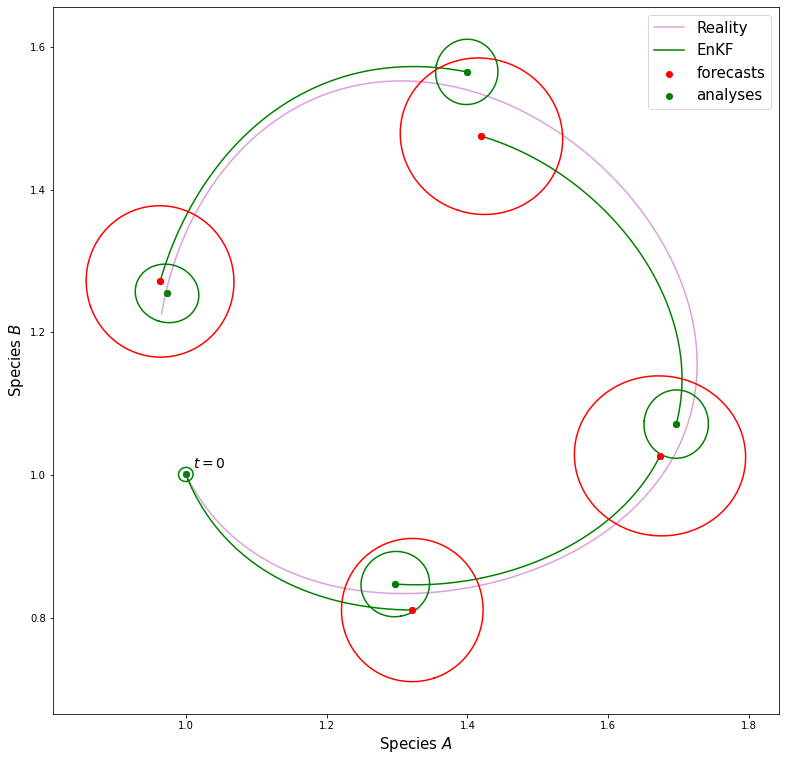

In [9]:
plt.figure(figsize=(13,13))

x_b = np.array([[1.0,1.0]])
x_t = x_b
sigma_b = np.eye(2) * 0.01**2

true_parameters = np.array([0.75, 0.65, 0.85])
reality = LotkaVolterra(*true_parameters,dt=1e-2,scheme='EE')

estimated_parameters = true_parameters + np.random.uniform(-0.05,.05,3)

Q = np.eye(2)* 0.1**2 #model error
time_window = 1.75 #forecast horizon

ensemble_size = 400
ensemble_b = np.random.multivariate_normal(x_b[0], sigma_b, ensemble_size)
enkf = LotkaVolterra(*estimated_parameters,dt=reality.dt,scheme='EE')


#data assimilation 
R = np.eye(2) *0.05**2  #observation error
H = np.eye(2)       #observation operator

n_cycles = 4
analyses = {0:ensemble_b.mean(axis=0)}
analyses_cov_matrix = {0:np.cov(ensemble_b.T)}
forecasts = {}
forecasts_cov_matrix = {}

t = 0
for i in range(n_cycles):
    times, traj_reality = reality.forecast(x_t, t + time_window, t0 = t, time_saving_interval=reality.dt, show_pbar =False)
    times, traj_enkf =    enkf.forecast(ensemble_b, t + time_window, t0 = t, time_saving_interval=reality.dt, show_pbar =False)
    reality.plot(times, traj_reality,c='plum',label='Reality' if i == n_cycles -1 else None)
    enkf.plot(times, traj_enkf,c='g',label='EnKF' if i == n_cycles -1 else None)
    
    t = times[-1]
    x_t = traj_reality[t]
    enkf_f = traj_enkf[t]
    
    y = np.random.multivariate_normal(traj_reality[t][0], R)
    ensemble_b = enkf.assimilation(enkf_f, y, H, R, Q)
    
    forecasts[t] = enkf_f.mean(axis=0)
    forecasts_cov_matrix[t] = np.cov(enkf_f.T) + Q
    analyses[t] = ensemble_b.mean(axis=0)
    analyses_cov_matrix[t] = np.cov(ensemble_b.T)

    
plt.xlabel("Species $A$",fontsize=15)
plt.ylabel("Species $B$",fontsize=15);
plt.text(x_b[0,0]+.01,x_b[0,1]+.01,'$t=0$',fontsize=14)

for t in forecasts.keys(): 
    label = 'forecasts' if t == list(forecasts.keys())[-1] else None
    plt.scatter(*forecasts[t],zorder=3,label=label,c='r')
    draw_covariance_matrix(forecasts[t],forecasts_cov_matrix[t],c='r')
    
for t in analyses.keys(): 
    label = 'analyses' if t == list(analyses.keys())[-1] else None
    plt.scatter(*analyses[t],zorder=3,label=label,c='g')
    draw_covariance_matrix(analyses[t],analyses_cov_matrix[t],c='g')
    
plt.legend(fontsize=15);

Here we illustrated the fact that thanks to the EnKF, even if our model is off by some degree, and that we dispose of observations, we are still able to correct our ensemble when new data becomes available, keeping us on an acceptable trajectory.

# 3. EnKF and PKF <a class="anchor" id="section3"></a>

In this 0D context, the covariance model used in the PKF is simply the three parameters of the covariance matrix, that is $(V_A,V_B,V_{AB})$. The dynamics of the complete PKF system are given by :
$$
\left\lbrace
\begin{array}{lcl}
\partial_t \overline{A}= a \overline{A} -b\overline{A}B - b V_{AB}\\
\partial_t \overline{B} = - c \overline{B} +d\overline{A}\overline{B} +dV_{AB}\\
\partial_t V_{AB} = V_{AB} (a - b \overline{B} -c +d\overline{A}) + d V_A \overline{B} -b V_B \overline{A} \\
\partial_t V_A = 2 [ V_A(a-b\overline{B}) - b \overline{A}V_{AB}] \\
\partial_t V_B = 2 [ V_B(-c+d\overline{A}) +d \overline{B}V_{AB}]\\
\end{array} 
\right.
$$

__Remark :__ this system is an approximation of the true dynamics, which are unknown. A tangeant linear approach is considered, neglecting moments of order higher to 3.

Below is a comparison of the forecasts given by the PKF and by a large EnKF.

1301it [00:03, 427.71it/s]                          
1301it [00:00, 33247.77it/s]            


Sampling noise : 0.4%


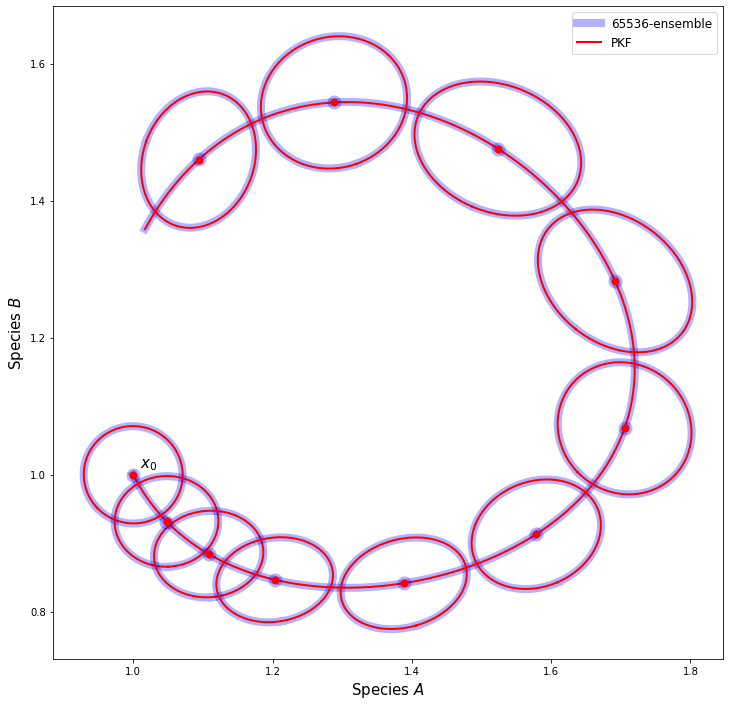

In [7]:
x0b = np.array([1,1])
sigma0 = 0.005* np.eye(2)
t_end = 6.5
ensemble_size = 4**8


k1,k2,k3 = 0.75, 0.65, 0.85

#Ensemble :
ensemble0 = np.random.multivariate_normal(x0b, sigma0, ensemble_size)
enkf_lv = LotkaVolterra(k1,k2,k3,0.005,'RK4')

times, traj_enkf = enkf_lv.forecast(ensemble0, t_end, time_saving_interval=enkf_lv.dt)

# PKF :
state0_pkf = np.array([x0b[0],x0b[1],sigma0[0,0],sigma0[1,1],sigma0[0,1]])
pkf_lv =  LotkaVolterra_PKF(k1,k2,k3,enkf_lv.dt, scheme= 'RK4')
times, traj_pkf = pkf_lv.forecast(state0_pkf, t_end, time_saving_interval = enkf_lv.dt)

# Plotting :
plt.figure(figsize=(12,12))
enkf_lv.plot(times, traj_enkf,label=f'{ensemble_size}-ensemble',c='b',linestyle='-',linewidth=8,alpha=0.3,zorder=1)

for time  in times[::70]:
    mean_enkf = traj_enkf[time].mean(axis=0)
    cov_mat_enkf = np.cov(traj_enkf[time].T)
    draw_covariance_matrix(mean_enkf,cov_mat_enkf,c='b',linewidth=8,alpha=0.3)
    
    mean_pkf = traj_pkf[time][:2]
    cov_mat_pkf = np.array([[traj_pkf[time][3],traj_pkf[time][2]],[traj_pkf[time][2],traj_pkf[time][4]]])
    draw_covariance_matrix(mean_pkf,cov_mat_enkf,c='r',linewidth=2)
    
    
pkf_lv.plot(times, traj_pkf, label='PKF',c='r',linewidth=2)

plt.legend(fontsize=12);
plt.xlabel('Species $A$',fontsize=15)
plt.ylabel('Species $B$',fontsize=15);
plt.text(1.01,1.01,'$x_0$',fontsize=15);
print("Sampling noise : {0:.1%}".format(1./ensemble_size**.5))

__Observation__ : Results are identical, except one method was $10^6$ times less expensive.